# Child Mind Institute — Problematic Internet Use

 [Link to the competition](https://www.kaggle.com/competitions/child-mind-institute-problematic-internet-use/data)




### Problem Statement
The goal of this competition is to develop a predictive model that analyzes children's physical activity and fitness data to identify early signs of problematic internet use. Identifying these patterns can help trigger interventions to encourage healthier digital habits.

### Objective
We are trying to predict a participant's Severity Impairment Index (SII), which is a standard measure of problematic internet use.

### Data
The dataset includes:

* Physical activity data: Wrist-worn accelerometer data, fitness assessments, and questionnaires.
* Internet usage behavior data: Information on how participants use the internet.

### Features and Their Meaning
* Accelerometer data: Measures physical activity levels.
* Fitness assessments: Evaluates physical fitness.
* Questionnaires: Collects self-reported data on internet usage and related behaviors.
* Internet usage data: Tracks the amount and type of internet use

Install Dependencies and Load Dataset

In [1]:
!pip install keras-tuner kaggle

In [2]:
import os
## Upload kaggle.json to session storage before running code
# from google.colab import files
# files.upload()

from google.colab import drive
drive.mount('/content/drive', force_remount=True)

#check if kaggle.json is in the current directory
os.chdir('/')

if 'kaggle.json' in os.listdir():
    print("kaggle.json is in the current directory")
else:
    print("kaggle.json is not in the current directory")

Mounted at /content/drive
kaggle.json is in the current directory


In [3]:
# Shifting kaggle.json credentials to appropriate folder and adding permissions
!mkdir -p ~/.kaggle
!cp /kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [4]:
filename = 'child-mind-institute-problematic-internet-use.zip'

# Check if the file already exists in the current directory
if os.path.isfile(filename):
    print(f"{filename} already exists in the current directory. Skipping download.")
else:
    # Download the competition files
    !kaggle competitions download -c child-mind-institute-problematic-internet-use
    !unzip ./child-mind-institute-problematic-internet-use.zip


100% 6.19G/6.21G [01:38<00:00, 97.7MB/s]
100% 6.21G/6.21G [01:38<00:00, 67.8MB/s]
Archive:  ./child-mind-institute-problematic-internet-use.zip
  inflating: data_dictionary.csv     
  inflating: sample_submission.csv   
  inflating: series_test.parquet/id=00115b9f/part-0.parquet  
  inflating: series_test.parquet/id=001f3379/part-0.parquet  
  inflating: series_train.parquet/id=00115b9f/part-0.parquet  
  inflating: series_train.parquet/id=001f3379/part-0.parquet  
  inflating: series_train.parquet/id=00f332d1/part-0.parquet  
  inflating: series_train.parquet/id=01085eb3/part-0.parquet  
  inflating: series_train.parquet/id=012cadd8/part-0.parquet  
  inflating: series_train.parquet/id=012e3869/part-0.parquet  
  inflating: series_train.parquet/id=029a19c9/part-0.parquet  
  inflating: series_train.parquet/id=02cebf33/part-0.parquet  
  inflating: series_train.parquet/id=02cf7384/part-0.parquet  
  inflating: series_train.parquet/id=035c96dd/part-0.parquet  
  inflating: series_train.

Import Libraries

In [5]:
# Import libraries and modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import os

import tensorflow as tf
from tensorflow import keras
import keras_tuner as kt
from tensorflow.keras.regularizers import l2                                                                # For L2 regularization to prevent overfitting
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau                                     # For learning rate scheduling and early stopping
from tensorflow.keras.models import Sequential                                                              # For creating a sequential model
from tensorflow.keras.layers import Dense, Dropout                                                          # For adding dense and dropout layers to the model
from tensorflow.keras.optimizers import Adam                                                                # For using Adam optimizer
from tensorflow.keras.utils import to_categorical


from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, accuracy_score, cohen_kappa_score # For evaluating classification performance
from sklearn.utils.class_weight import compute_class_weight                                                                    # For computing class weights to handle class imbalance
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.impute import KNNImputer


from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier


In [6]:
# Load the data from the csv file
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')

In [7]:
# Display the first five rows of the test dataset
df_test.head()

,id,Basic_Demos-Enroll_Season,Basic_Demos-Age,Basic_Demos-Sex,CGAS-Season,CGAS-CGAS_Score,Physical-Season,Physical-BMI,Physical-Height,Physical-Weight,...,BIA-BIA_TBW,PAQ_A-Season,PAQ_A-PAQ_A_Total,PAQ_C-Season,PAQ_C-PAQ_C_Total,SDS-Season,SDS-SDS_Total_Raw,SDS-SDS_Total_T,PreInt_EduHx-Season,PreInt_EduHx-computerinternet_hoursday
0,00008ff9,Fall,5,0,Winter,51.0,Fall,16.877316,46.0,50.8,...,32.6909,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Fall,3.0
1,000fd460,Summer,9,0,NaN,NaN,Fall,14.035590,48.0,46.0,...,27.0552,NaN,NaN,Fall,2.340,Fall,46.0,64.0,Summer,0.0
2,00105258,Summer,10,1,Fall,71.0,Fall,16.648696,56.5,75.6,...,NaN,NaN,NaN,Summer,2.170,Fall,38.0,54.0,Summer,2.0
3,00115b9f,Winter,9,0,Fall,71.0,Summer,18.292347,56.0,81.6,...,45.9966,NaN,NaN,Winter,2.451,Summer,31.0,45.0,Winter,0.0
4,0016bb22,Spring,18,1,Summer,NaN,NaN,NaN,NaN,NaN,...,NaN,Summer,1.04,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Understand the Dataset

In [8]:
# Check the shape of the data to understand the structure
print("Training data shape:", df_train.shape)
print("Test data shape:", df_test.shape)

# Display the types of the columns in the dataset
print("Data types in the training data columns:", df_train.dtypes)
print("Data types in the test data columns:", df_test.dtypes)

Training data shape: (3960, 82)
Test data shape: (20, 59)
Data types in the training data columns: id                                         object
Basic_Demos-Enroll_Season                  object
Basic_Demos-Age                             int64
Basic_Demos-Sex                             int64
CGAS-Season                                object
                                           ...   
SDS-SDS_Total_Raw                         float64
SDS-SDS_Total_T                           float64
PreInt_EduHx-Season                        object
PreInt_EduHx-computerinternet_hoursday    float64
sii                                       float64
Length: 82, dtype: object
Data types in the test data columns: id                                         object
Basic_Demos-Enroll_Season                  object
Basic_Demos-Age                             int64
Basic_Demos-Sex                             int64
CGAS-Season                                object
CGAS-CGAS_Score                       

Training Data: The shape (3960, 82) shows there are 3,960 rows and 82 columns in the training dataset.

Test Data: The shape (20, 59) indicates there are 20 rows and 59 columns in the test dataset.

The data types are categorized as object, int64, or float64.

Object: Used for categorical variables or text data, such as Enroll_Season, Sex, and other seasonal or categorical indicators.

Int64: Represents integer values including age and other discrete numerical data.

Float64: Represents continuous numerical values, including scores and physical measurements including CGAS_Score, Physical-BMI, and SDS_Total_Raw.

# Exploratory Data Analysis

In [9]:
# Display the summary statistics for the training dataset
print("Summary of Training Data:\n")
df_train.describe()

Summary of Training Data:



,Basic_Demos-Age,Basic_Demos-Sex,CGAS-CGAS_Score,Physical-BMI,Physical-Height,Physical-Weight,Physical-Waist_Circumference,Physical-Diastolic_BP,Physical-HeartRate,Physical-Systolic_BP,...,PCIAT-PCIAT_16,PCIAT-PCIAT_17,PCIAT-PCIAT_18,PCIAT-PCIAT_19,PCIAT-PCIAT_20,PCIAT-PCIAT_Total,SDS-SDS_Total_Raw,SDS-SDS_Total_T,PreInt_EduHx-computerinternet_hoursday,sii
count,3960.000000,3960.000000,2421.000000,3022.000000,3027.000000,3076.000000,898.000000,2954.000000,2967.000000,2954.000000,...,2728.000000,2725.000000,2728.000000,2730.000000,2733.000000,2736.000000,2609.000000,2606.000000,3301.000000,2736.000000
mean,10.433586,0.372727,65.454771,19.331929,55.946713,89.038615,27.278508,69.648951,81.597236,116.983074,...,1.452346,1.627890,1.613636,1.158974,0.943652,27.896199,41.088923,57.763622,1.060588,0.580409
std,3.574648,0.483591,22.341862,5.113934,7.473764,44.569040,5.567287,13.611226,13.665196,17.061225,...,1.495600,1.445622,1.529178,1.343661,1.185460,20.338853,10.427433,13.196091,1.094875,0.771122
min,5.000000,0.000000,25.000000,0.000000,33.000000,0.000000,18.000000,0.000000,27.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,17.000000,38.000000,0.000000,0.000000
25%,8.000000,0.000000,59.000000,15.869350,50.000000,57.200000,23.000000,61.000000,72.000000,107.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,12.000000,33.000000,47.000000,0.000000,0.000000
50%,10.000000,0.000000,65.000000,17.937682,55.000000,77.000000,26.000000,68.000000,81.000000,114.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,26.000000,39.000000,55.000000,1.000000,0.000000
75%,13.000000,1.000000,75.000000,21.571244,62.000000,113.800000,30.000000,76.000000,90.500000,125.000000,...,2.000000,3.000000,2.000000,2.000000,1.000000,41.000000,46.000000,64.000000,2.000000,1.000000
max,22.000000,1.000000,999.000000,59.132048,78.500000,315.000000,50.000000,179.000000,138.000000,203.000000,...,5.000000,5.000000,5.000000,5.000000,5.000000,93.000000,96.000000,100.000000,3.000000,3.000000


In [10]:
# Display the summary statistics for the test dataset
print("Summary of Test Data:\n")
df_test.describe()

Summary of Test Data:



,Basic_Demos-Age,Basic_Demos-Sex,CGAS-CGAS_Score,Physical-BMI,Physical-Height,Physical-Weight,Physical-Waist_Circumference,Physical-Diastolic_BP,Physical-HeartRate,Physical-Systolic_BP,...,BIA-BIA_ICW,BIA-BIA_LDM,BIA-BIA_LST,BIA-BIA_SMM,BIA-BIA_TBW,PAQ_A-PAQ_A_Total,PAQ_C-PAQ_C_Total,SDS-SDS_Total_Raw,SDS-SDS_Total_T,PreInt_EduHx-computerinternet_hoursday
count,20.000000,20.000000,8.000000,13.000000,13.000000,13.000000,5.000000,11.000000,12.000000,11.000000,...,8.000000,8.000000,8.000000,8.000000,8.000000,1.00,9.000000,10.000000,10.00000,16.000000
mean,10.750000,0.400000,62.500000,19.835939,52.961538,79.200000,25.400000,70.545455,81.666667,117.545455,...,28.486750,15.457795,56.989275,25.985962,45.167825,1.04,2.372333,36.800000,52.30000,1.437500
std,3.725799,0.502625,11.275764,4.927625,6.942357,23.632181,3.130495,18.806189,9.316001,21.262002,...,5.099449,4.021153,14.490362,7.479799,11.940000,NaN,1.080099,5.533735,7.02456,1.152895
min,5.000000,0.000000,50.000000,14.035590,37.500000,46.000000,22.000000,57.000000,70.000000,95.000000,...,21.035200,8.895360,38.917700,15.410700,27.055200,1.04,1.100000,27.000000,40.00000,0.000000
25%,9.000000,0.000000,51.000000,16.861286,48.000000,60.200000,24.000000,60.500000,74.500000,102.500000,...,24.230725,13.815400,44.627250,19.801775,37.245575,1.04,1.270000,33.500000,47.75000,0.000000
50%,10.000000,0.000000,63.000000,18.292347,55.000000,81.600000,24.000000,63.000000,80.000000,116.000000,...,29.470400,16.402450,59.199050,26.337750,46.608850,1.04,2.340000,37.500000,53.50000,2.000000
75%,12.250000,1.000000,71.000000,21.079065,57.750000,85.600000,27.000000,73.000000,90.250000,119.500000,...,31.398725,17.674625,65.222050,30.421100,51.860475,1.04,3.020000,39.750000,55.75000,2.000000
max,19.000000,1.000000,80.000000,30.094649,60.000000,121.600000,30.000000,123.000000,97.000000,163.000000,...,36.057200,20.902000,79.698200,36.223200,63.126500,1.04,4.110000,46.000000,64.00000,3.000000


### Exploration of SII

SII, otherwise known as the Social Interaction Inventory, is a metric used to assess an individual's social interaction patterns that focuses on aspects including the frequency and quality of the social engagements. SII is the target variable used in this study that is evaluted to better understand the relationship between social interaction levels and internet usage behaviors.  

In [11]:
data = {0: 'None', 1: 'Mild', 2: 'Moderate', 3: 'Severe'}
plot_sii = [data[x] for x in df_train['sii'].dropna()]
#plot_sii

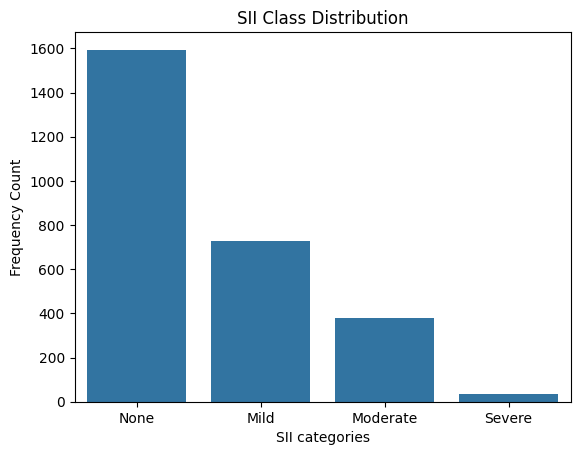

In [12]:
# Visualize the Class Distribution
# Count of each class in training set
sns.countplot(x=plot_sii, order=['None', 'Mild', 'Moderate', 'Severe'])  # target variable is sii

plt.title('SII Class Distribution')
plt.xlabel('SII categories')
plt.ylabel('Frequency Count')
plt.show()

Insights for SII distribution: There is a high count of patients who fall under the category of having a low Severity Impairment Index (almost 1600 patients), with a tiny population of patients with a severe impairment index. This could potentially affect the training of the model and its accuracy in detecting patients categorized with having a severity impairment index.

Severity Impairment Index for reference: 0-30=None; 31-49=Mild; 50-79=Moderate; 80-100=Severe, where the 0-100 is derived from the PCIAT-PCIAT_Total variable which aggregates the scores from the different severity detection tests.

If the SII score has class imbalance, where there is a skewed distribution with more high or low scores than others, it can be handled by adopting the following strategies:

- Oversampling the minority class

- Undersampling the majority class (which would reduce the data size, but balance the classes)

- Adjust class weights so that the model penalizes missclassifications of the minority class significantly.

- If the imbalance is too much, the minority class can be identified as an anomaly and anomaly detection techniques can be utilized to better handle the distributions.

- Utilize metrics that are less sensitive to class imbalance such as F1-score, Balanced Accuracy, or AUC-ROC.


### Exploration of Features

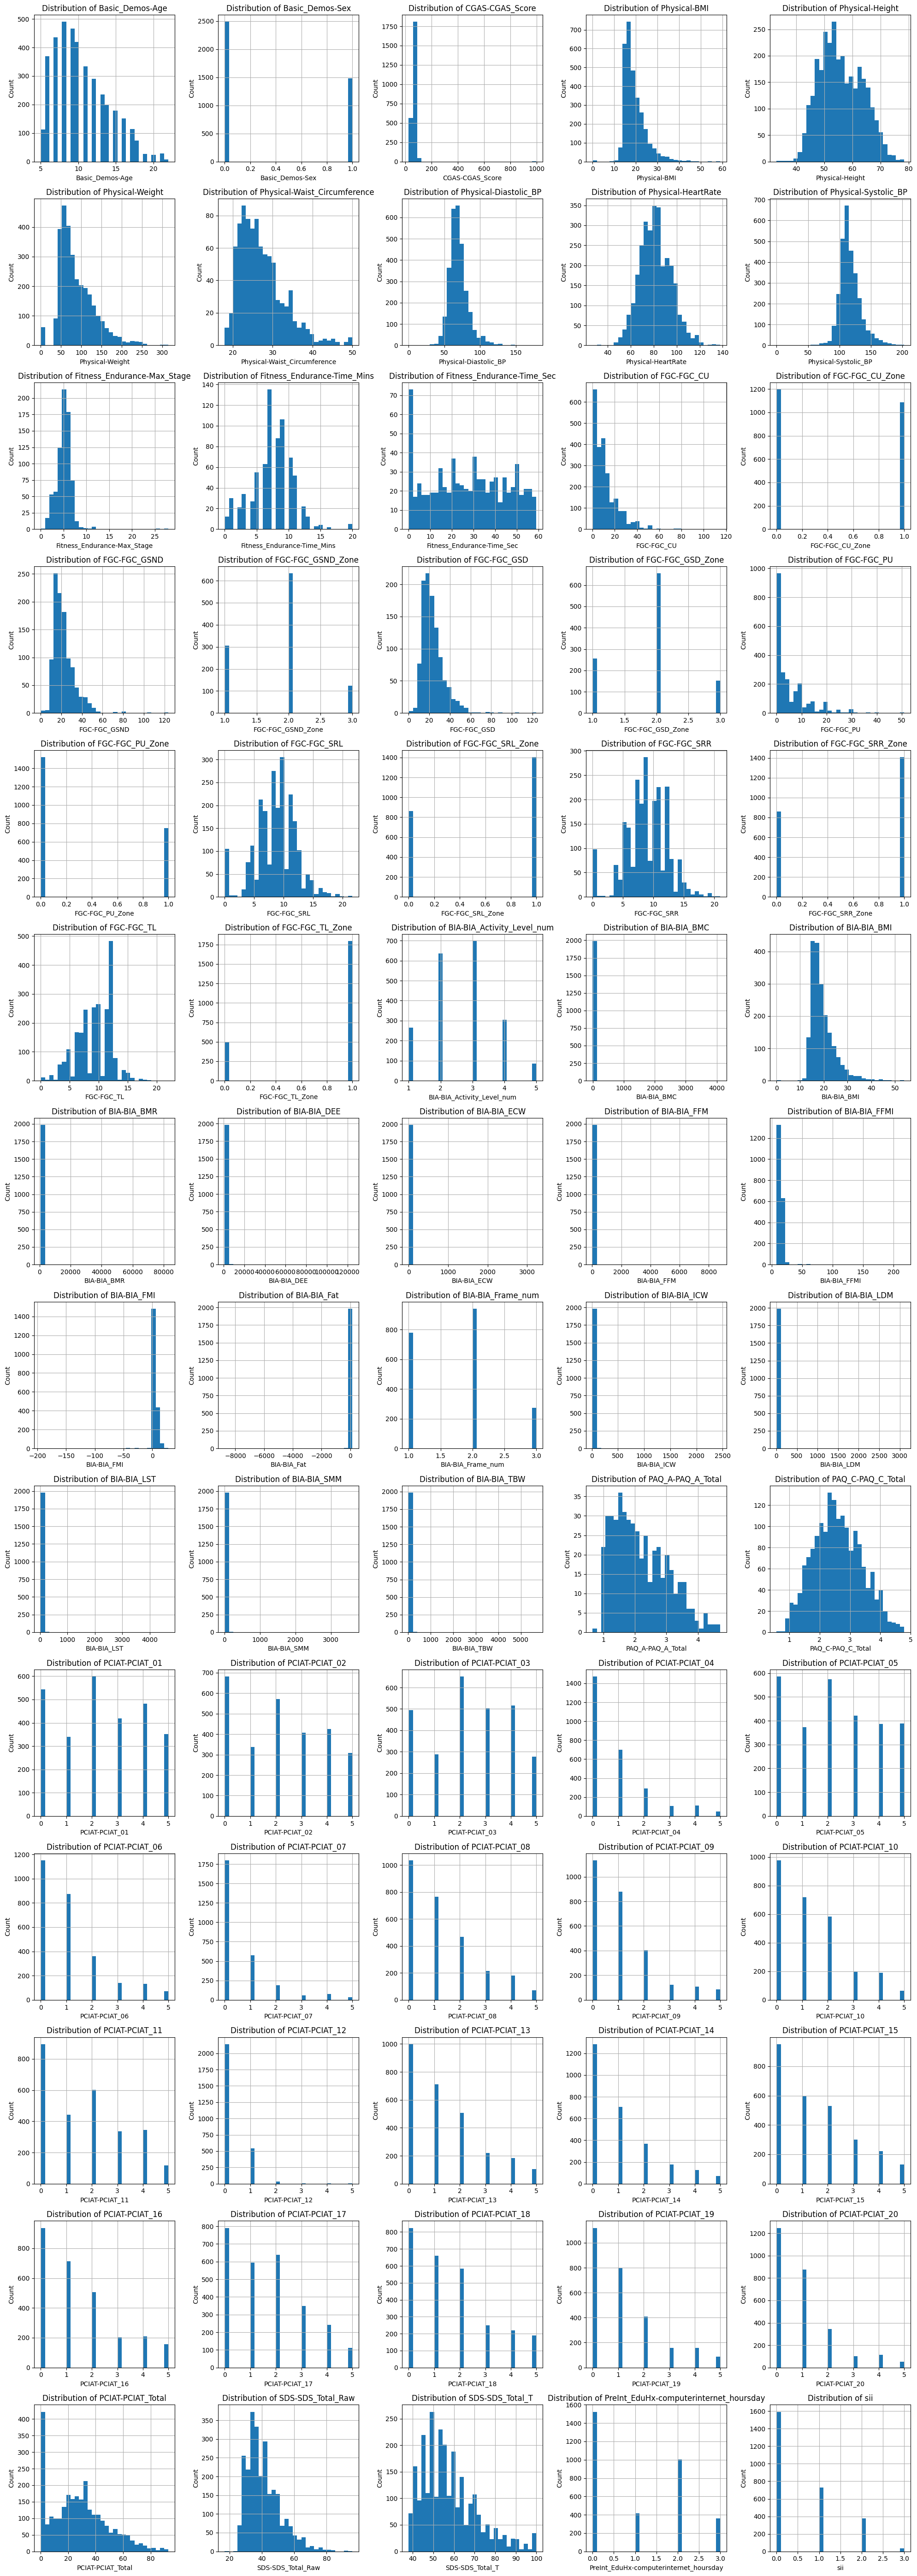

In [13]:
# Define the number of columns for the grid layout
n_cols = 5
numeric_columns = df_train.select_dtypes(include=[np.number]).columns
n_rows = (len(numeric_columns) + n_cols - 1) // n_cols  # Calculate the number of rows needed

# Set up the figure and axes
fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 4 * n_rows))
axes = axes.flatten()  # Flatten the axes array for easy iteration

# Plot each histogram in the grid
for i, col in enumerate(numeric_columns):
    df_train[col].hist(bins=30, ax=axes[i])
    axes[i].set_title(f'Distribution of {col}', fontsize=12)
    axes[i].set_xlabel(col, fontsize=10)  # Set x-axis label to the column name
    axes[i].set_ylabel('Count', fontsize=10)  # Set y-axis label to "Count"

# Turn off any unused subplots
for j in range(i + 1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()


Insights from histogram of numeric columns: Overall, we're seeing that the categorial data is not balanced between classes. With the student measurements, some features are normally distributed, but some features are positively skewed. The issue with imbalaced data is that our model will be biased towards the majority class. This could lead to misleading accuracy. As mentioned for SII, we can use oversampling or undersampling to help correct this issue.

While there are a lot of histograms presented here, we have yet to narrow down on features. This is required to determine which features will be useful in our model building.

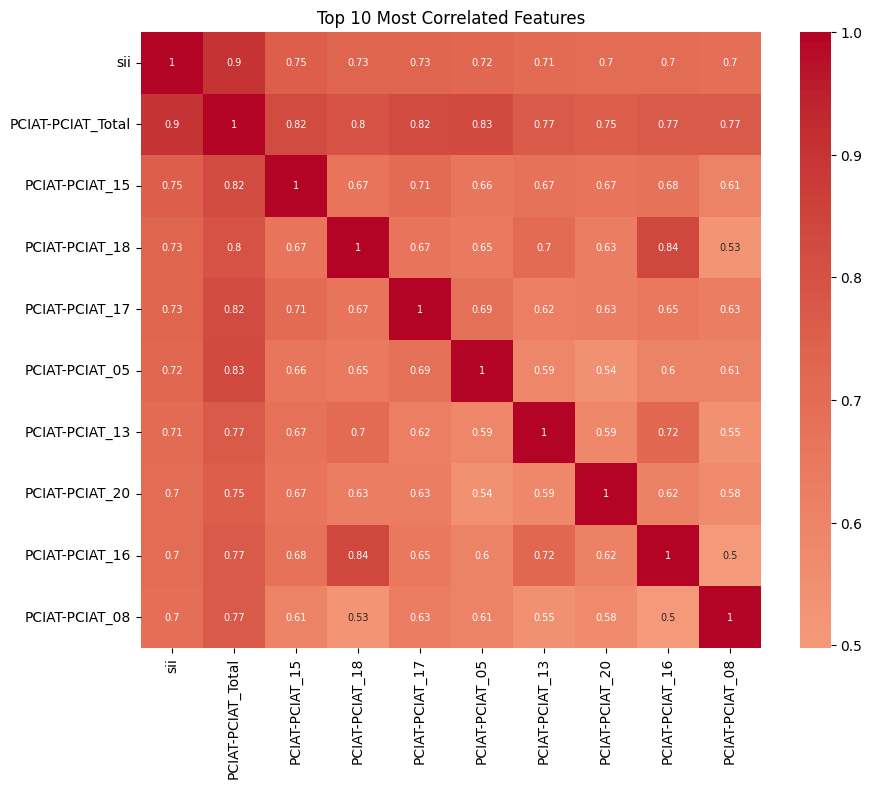

In [14]:
# Sort the features based on their correlation with a specific column
numeric_df = df_train.select_dtypes(include=[np.number])
corr_matrix = numeric_df.corr()
sorted_corr = corr_matrix['sii'].sort_values(ascending=False)

# Plot only the top 10 most correlated features
top_corr = sorted_corr.index[:10]
plt.figure(figsize=(10, 8))
sns.heatmap(numeric_df[top_corr].corr(), annot=True, cmap='coolwarm', center=0, annot_kws={"size": 7})
plt.title('Top 10 Most Correlated Features')
plt.show()


Insights for top ten most correlated features with SII: The aggregate of Parent-Child Internet Addiction Test (PC-IAT_Total) has the highest correlation with SII, which matches the data dictionary description of SII being derived from this field. It is interesting to note that the PCIAT-15 (How often does your child seem preoccupied with being back online when off-line?) has the second highest correlation with SII as a relationship.

In [15]:
# Identify minimum and maximum numeric values

print("Minimum values for each column:\n", numeric_df.min())
print("Maximum values for each column:\n", numeric_df.max())

Minimum values for each column:
 Basic_Demos-Age                            5.0
Basic_Demos-Sex                            0.0
CGAS-CGAS_Score                           25.0
Physical-BMI                               0.0
Physical-Height                           33.0
                                          ... 
PCIAT-PCIAT_Total                          0.0
SDS-SDS_Total_Raw                         17.0
SDS-SDS_Total_T                           38.0
PreInt_EduHx-computerinternet_hoursday     0.0
sii                                        0.0
Length: 70, dtype: float64
Maximum values for each column:
 Basic_Demos-Age                            22.000000
Basic_Demos-Sex                             1.000000
CGAS-CGAS_Score                           999.000000
Physical-BMI                               59.132048
Physical-Height                            78.500000
                                             ...    
PCIAT-PCIAT_Total                          93.000000
SDS-SDS_Total_Raw  

### Summary of EDA

*   Training has 3960 rows, which is a much smaller amount of data than the Kaggle Competition led us to believe. This is a good thing, as we were worried we'd have too much data and have to filter it down.
*   Test data only has 20 rows, which is 99% less than training. This is problematic, and we'll likely need to using the training data to build our training, validation and test dataframes.
*   Most of the data is either categorical integers or measurements at floats.
*   There is imbalanced data that will need to be accounted for in the ETL section.
*   SII has the highest correlation with `PCIAT-PCIAT_Total`, which lead us to read further into the calculations and find that SII is derived from the PCIAT values. These columns should be dropped in the ETL section.



# ETL and Data Prep

In the EDA, we found an inbalance of classes and significant missing values. In this next section, we will prepare the data for training.

In [16]:
# Load the data from the csv file
df_train = pd.read_csv('train.csv')
df_train.shape

(3960, 82)

In [17]:
#check if id is unique for all rows
df_train['id'].is_unique

True

In [18]:
# Check for Missing Data
#drop rows where sii is null because if our target is missing, the data will not be valuable for training and validation
df_train = df_train.dropna(subset=['sii'])

PCIAT_columns = [
    "PCIAT-PCIAT_01",
    "PCIAT-PCIAT_02",
    "PCIAT-PCIAT_03",
    "PCIAT-PCIAT_04",
    "PCIAT-PCIAT_05",
    "PCIAT-PCIAT_06",
    "PCIAT-PCIAT_07",
    "PCIAT-PCIAT_08",
    "PCIAT-PCIAT_09",
    "PCIAT-PCIAT_10",
    "PCIAT-PCIAT_11",
    "PCIAT-PCIAT_12",
    "PCIAT-PCIAT_13",
    "PCIAT-PCIAT_14",
    "PCIAT-PCIAT_15",
    "PCIAT-PCIAT_16",
    "PCIAT-PCIAT_17",
    "PCIAT-PCIAT_18",
    "PCIAT-PCIAT_19",
    "PCIAT-PCIAT_20",
    "PCIAT-PCIAT_Total"
]

#drop PCIAT-PCIAT data because these values are used to calculate the SII values
df_train = df_train.drop(PCIAT_columns, axis=1)

There are 11 different columns for seasons. We need to understand how these are related and whether the information is needed for the model.

In [19]:
#handle seasons data
#for each row, check if all the season values are the same. Count the number of rows that the season varies
season_columns = ['Basic_Demos-Enroll_Season', 'CGAS-Season', 'Physical-Season', 'Fitness_Endurance-Season', 'FGC-Season', 'BIA-Season', 'PAQ_A-Season', 'PAQ_C-Season', 'PCIAT-Season', 'SDS-Season', 'PreInt_EduHx-Season']
all_seasons_same = df_train[season_columns].apply(lambda x: len(x.unique()) == 1, axis=1)
#print rows that the season was not the same and only print the season_columns
print(df_train[~all_seasons_same][season_columns])


     Basic_Demos-Enroll_Season CGAS-Season Physical-Season  \
0                         Fall      Winter            Fall   
1                       Summer         NaN            Fall   
2                       Summer        Fall            Fall   
3                       Winter        Fall          Summer   
5                       Spring      Winter          Summer   
...                        ...         ...             ...   
3953                      Fall         NaN            Fall   
3954                    Summer         NaN          Summer   
3955                      Fall      Spring            Fall   
3957                      Fall      Spring          Winter   
3958                    Spring      Spring          Winter   

     Fitness_Endurance-Season FGC-Season BIA-Season PAQ_A-Season PAQ_C-Season  \
0                         NaN       Fall       Fall          NaN          NaN   
1                         NaN       Fall     Winter          NaN         Fall   
2           

In [20]:
#dropping season columns since the documnetation is unclear of the relationship between the different the 11 difference season columns
df_train = df_train.drop(season_columns, axis=1)
df_train.shape

(2736, 50)

### Missing Data
There is a lot of missing data in the dataset. We will start by understanding what columns have the most missing data, then determine how to mitigate the missing data.

In [21]:
#explore which features have the most null values
#create a df of the columns that have non-zero sum of nulls, sort highest to lowest
def count_nulls(df, threshold):
    null_counts = df.isnull().sum()
    null_counts = null_counts[null_counts > threshold]
    null_counts = null_counts.sort_values(ascending=False)
    return null_counts

count_nulls(df_train, 0)

,0
PAQ_A-PAQ_A_Total,2373
Physical-Waist_Circumference,2253
Fitness_Endurance-Time_Mins,2008
Fitness_Endurance-Time_Sec,2008
Fitness_Endurance-Max_Stage,2005
FGC-FGC_GSND_Zone,1872
FGC-FGC_GSD_Zone,1872
FGC-FGC_GSD,1865
FGC-FGC_GSND,1864
PAQ_C-PAQ_C_Total,1296


PAQ_A-PAQ_A_Total and PAQ_C-PAQ_C_Total represent the activity summary score, were 'A' represents Adolescents and 'C' represents Children. Theoretically, this could be a single column. First, we need to check if there are any rows that have values for both PAQ_A-PAQ_A_Total and PAQ_C-PAQ_C_Total since a participant should either be a child or adolescent.

In [22]:
#are there any rows that have values for both PAQ_A-PAQ_A_Total and PAQ_C-PAQ_C_Total?
mask_paq_a = df_train['PAQ_A-PAQ_A_Total'].notnull()
mask_paq_c = df_train['PAQ_C-PAQ_C_Total'].notnull()
mask_both = mask_paq_a & mask_paq_c
rows_with_both = df_train[mask_both]

#print rows with both, along with age and ID
#print(rows_with_both[['id', 'Basic_Demos-Age', 'PAQ_A-PAQ_A_Total', 'PAQ_C-PAQ_C_Total']])

#how many rows have neither PAQ_A-PAQ_A_Total or PAQ_C-PAQ_C_Total
rows_with_neither = df_train[~mask_both]
print("Count of rows with neither PAQ_A-PAQ_A_Total or PAQ_C-PAQ_C_Total", rows_with_neither.shape[0])

#assuming this is an error, that a participant can't be both a child and an adolescent, drop the affected row from train_df
df_train = df_train.drop(rows_with_both.index)

df_train = df_train.drop(['PAQ_A-PAQ_A_Total', 'PAQ_C-PAQ_C_Total'], axis=1)


Count of rows with neither PAQ_A-PAQ_A_Total or PAQ_C-PAQ_C_Total 2735


There are 2735 rows missing both PAQ_A-PAQ_A_Total and PAQ_C-PAQ_C_Total of the 3960 rows. This is too much missing data. If we use techniques like filling with the average value, this large ratio of missing data would not make this feature valuable to our model.

With the same logic we will drop Physical Waist Circumference, Fitness Endurance and Grip Strength data, since ~2000 values of the 3960 rows are missing. We can get a similar measure of the participants physical health with their weight. The endurace and grip strength data is more unique, but other Fitness Gram metrics should give us similar insights.



In [23]:
#drop Physical-Waist_Circumference
df_train = df_train.drop(['Physical-Waist_Circumference'], axis=1)
df_train = df_train.drop(['Fitness_Endurance-Time_Mins'], axis=1)
df_train = df_train.drop(['Fitness_Endurance-Time_Sec'], axis=1)
df_train = df_train.drop(['Fitness_Endurance-Max_Stage'], axis=1)
df_train = df_train.drop(['FGC-FGC_GSND'], axis=1)
df_train = df_train.drop(['FGC-FGC_GSND_Zone'], axis=1)
df_train = df_train.drop(['FGC-FGC_GSD'], axis=1)
df_train = df_train.drop(['FGC-FGC_GSD_Zone'], axis=1)


There are 922 rows with missing Bio-electric Impedance Analysis (BIA) data. Going to explore how to handle this.

In [24]:
BIA_columns = [
    "BIA-BIA_Activity_Level_num",
    "BIA-BIA_BMC",
    "BIA-BIA_BMI",
    "BIA-BIA_BMR",
    "BIA-BIA_DEE",
    "BIA-BIA_ECW",
    "BIA-BIA_FFM",
    "BIA-BIA_FFMI",
    "BIA-BIA_FMI",
    "BIA-BIA_Fat",
    "BIA-BIA_Frame_num",
    "BIA-BIA_ICW",
    "BIA-BIA_LDM",
    "BIA-BIA_LST",
    "BIA-BIA_SMM",
    "BIA-BIA_TBW"
]

In [25]:
#print rows where the BIA columns are null and only show the BIA columns
df_train[df_train[BIA_columns].isnull().any(axis=1)][BIA_columns]

,BIA-BIA_Activity_Level_num,BIA-BIA_BMC,BIA-BIA_BMI,BIA-BIA_BMR,BIA-BIA_DEE,BIA-BIA_ECW,BIA-BIA_FFM,BIA-BIA_FFMI,BIA-BIA_FMI,BIA-BIA_Fat,BIA-BIA_Frame_num,BIA-BIA_ICW,BIA-BIA_LDM,BIA-BIA_LST,BIA-BIA_SMM,BIA-BIA_TBW
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
16,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
21,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3938,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3941,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3942,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3948,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [26]:
#drop rows where all the BIA columns are missing
df_train = df_train.dropna(subset=BIA_columns, how='all')
df_train.shape

(1813, 40)

It seems that in those 922 rows, all BIA data is missing. Since this data is valuable to our analysis, we decided to drop those 922 rows.

The rest of the columns have 200 or less missing values. We decided to use the average value of those columns to fill the missing values.

In [27]:
null_column_counts = count_nulls(df_train, 0)
#find the average value of non-NaN rows for columns in null_column_counts
null_columns = null_column_counts.index.tolist()
average_values = df_train[null_columns].mean()
#print(average_values)

#for missing values in df_train, fill the missing value with the average found in average_values
df_train = df_train.fillna(average_values)
df_train.shape


(1813, 40)

Given that the test Data has a shape of (20, 59), indicating
 that there are 20 rows and 59 columns in the test dataset, we will utilize a split of the train dataset for our model as it will provide a lot more samples (more than 20) for our testing purposes.

In [28]:
## Check if data is formatted correctly for further usage / processing
print(df_train.dtypes) # Check data types of columns

#drop ID
df_train = df_train.drop(['id'], axis=1)


id                                         object
Basic_Demos-Age                             int64
Basic_Demos-Sex                             int64
CGAS-CGAS_Score                           float64
Physical-BMI                              float64
Physical-Height                           float64
Physical-Weight                           float64
Physical-Diastolic_BP                     float64
Physical-HeartRate                        float64
Physical-Systolic_BP                      float64
FGC-FGC_CU                                float64
FGC-FGC_CU_Zone                           float64
FGC-FGC_PU                                float64
FGC-FGC_PU_Zone                           float64
FGC-FGC_SRL                               float64
FGC-FGC_SRL_Zone                          float64
FGC-FGC_SRR                               float64
FGC-FGC_SRR_Zone                          float64
FGC-FGC_TL                                float64
FGC-FGC_TL_Zone                           float64


In [29]:
#split df_train into X_train and X_test using train_test_split
# Split the data into training and testing sets
X_train, X_test, Y_train, Y_test = train_test_split(df_train.drop(['sii'], axis=1), df_train['sii'], test_size=0.2, random_state=42)

#print shape of each dataframe
print(X_train.shape)
print(X_test.shape)
print(Y_train.shape)
print(Y_test.shape)

(1450, 38)
(363, 38)
(1450,)
(363,)


### Imbalanced Data
Imbalanced data occurs when one class (majority class) has significantly more instances than another class (minority class). This can lead to biased models that perform poorly on the minority class, which is often the class of interest.One way to handle the imbalanced data we discovered during our EDA, is to undersample the majority class.

In [30]:
# use Random Under Sampler to under sample our data
undersampler = RandomUnderSampler(random_state=42)
X_resampled, y_resampled = undersampler.fit_resample(X_train, Y_train)

# Baseline Model

In [31]:
# Building a model

def build_model(n_classes,
                learning_rate=0.01,
                metric='metric'):
    """Build a multi-class logistic regression model using Keras.

    Args:
    n_classes: Number of output classes in the dataset.
    learning_rate: The desired learning rate for the optimizer.
    metric: The desired metric.

    Returns:
    model: A tf.keras model (graph).
    """
    tf.keras.backend.clear_session()
    np.random.seed(0)
    tf.random.set_seed(0)

    # Build a model using keras.Sequential.
    model = tf.keras.models.Sequential()

    # create input layer
    model.add(keras.layers.Flatten(input_shape=[38], name='Input'))

    # create output layer
    model.add(keras.layers.Dense(
            units= n_classes,  # multiclass classification problem
            use_bias=True,
            activation='softmax',
            kernel_initializer=tf.ones_initializer,  # initialize params to 1
            bias_initializer=tf.ones_initializer,    # initialize bias to 1
            name='Output'
    ))

    # Utilizing Adam optimizer
    opt = tf.keras.optimizers.Adam(learning_rate = learning_rate)

    # Finally, compile the model. Select the accuracy metric. This finalizes the graph for training.
    model.compile(
        loss=tf.keras.losses.SparseCategoricalCrossentropy(),
        optimizer=opt,
        metrics = [metric]
    )

    return model

Also tested with Stochastic Gradient Descent optimizer, but Adam performed a lot better than SGD for both training and validation sets.

In [32]:
# Initial base model hyperparameters
num_output_classes = 4
initial_parameters = {
    'metric': 'accuracy',
    'learning_rate': 0.01
}

# Building model skeleton for the final fit
model = build_model(
          n_classes=num_output_classes,
          metric=initial_parameters['metric'],
          learning_rate=initial_parameters['learning_rate']
        )

/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


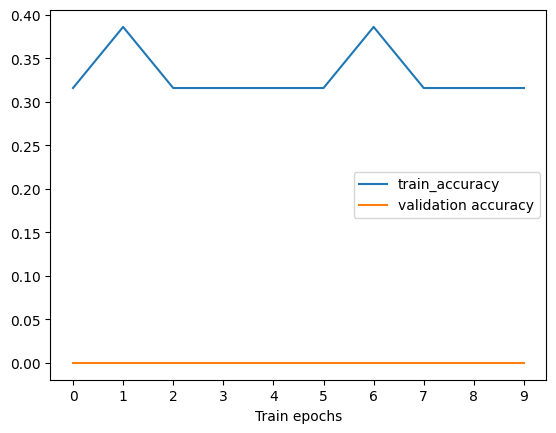


Training accuracy: 0.3158
Validation accuracy: 0.0000


In [33]:
# Additional hyperparameters
num_epochs = 10
batch_size = 64
validation_split = 0.2

# Fitting the model with the training data and additional hyperparameters
history = model.fit(
        x=X_resampled,
        y=y_resampled,
        epochs=num_epochs,
        batch_size=batch_size,
        validation_split=validation_split,
        verbose=0)

# Plotting the training metrics after each train epoch and the final validation accuracy.
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

# Plotting the training and validation accuracy after each training epoch
plt.plot(train_accuracy, label='train_accuracy')
plt.plot(val_accuracy, label='validation accuracy')
plt.xticks(range(num_epochs))
plt.xlabel('Train epochs')
plt.legend()
plt.show()

# Printing final accuracies
print('\nTraining accuracy: %1.4f' %train_accuracy[-1])
print('Validation accuracy: %1.4f' %val_accuracy[-1])

## Compute Metrics

Utilizing both accuracy and quadratic kappa as our initial base metrics and indicators as they help us understand the classifications from the model.

Computation of quadratic kappa metrics is becoming a standard for evaluating data that could include high level of bias for raters creating the data. It is a score between -1 and 1, where a score of 0.6 or higher is considered a better model. It allows for a more objective and reliable assessment of their agreement.


In [34]:
# Helper Function
def multiClassPredictionConverter(predictionArray):
    convertedArray = pd.DataFrame(predictionArray)
    convertedArray['max_col'] = convertedArray.idxmax(axis=1)
    convertedArray = convertedArray['max_col']
    return convertedArray

In [35]:
# Helper Function
def comprehensiveTestMetrics(modelName, Y_test, predictionArray):
    # Evaluate performance
    accuracy = accuracy_score(Y_test, predictionArray)           # Calculate the accuracy of the model on the test data
    class_report = classification_report(Y_test, predictionArray, zero_division = 0.0)      # Create a classification report that includes precision, recall, and F1-score
    conf_matrix = confusion_matrix(Y_test, predictionArray)      # Compute the confusion matrix to compare true vs. predicted labels
    quadKappaScore = cohen_kappa_score(Y_test, predictionArray, weights = 'quadratic')

    print("\n")
    print(modelName, "Test Performance:")
    print("  Test Accuracy:", round(accuracy,4))
    print("  Quadratic Kappa Score:", round(quadKappaScore,4))
    print("\nClassification Report:\n", class_report)
    disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
    disp.plot()

### Evaluation of Baseline

Y_train accuracy score:  0.584
Y_train quadratic kappa score:  0.045


Baseline Model Test Performance:
  Test Accuracy: 0.5785
  Quadratic Kappa Score: 0.0047

Classification Report:
               precision    recall  f1-score   support

         0.0       0.59      0.96      0.73       212
         1.0       0.38      0.06      0.10        99
         2.0       0.00      0.00      0.00        46
         3.0       0.00      0.00      0.00         6

    accuracy                           0.58       363
   macro avg       0.24      0.26      0.21       363
weighted avg       0.45      0.58      0.45       363



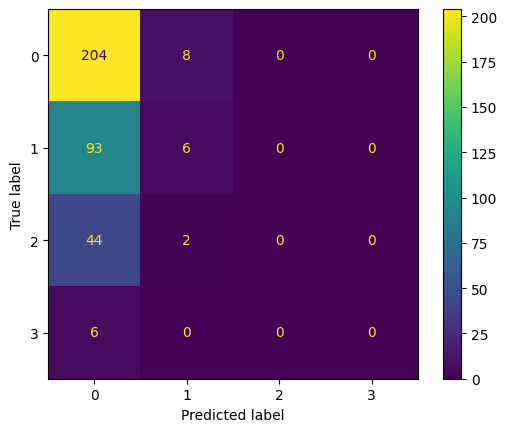

In [36]:
# Training dataset evaluation
training_evaluation = model.predict(X_train, verbose=0)
training_evaluation = pd.DataFrame(training_evaluation)
training_evaluation['max_col'] = training_evaluation.idxmax(axis=1)
training_evaluation = training_evaluation['max_col']
print("Y_train accuracy score: ", round(accuracy_score(Y_train, training_evaluation), 3))
print("Y_train quadratic kappa score: ", round(cohen_kappa_score(Y_train, training_evaluation, weights='quadratic'), 3))


# Testing dataset evaluation
test_prediction = model.predict(X_test, verbose=0)
test_prediction = multiClassPredictionConverter(test_prediction)

comprehensiveTestMetrics('Baseline Model', Y_test, test_prediction)

The above model is highly skewed towards the classes with high class samples. With a quadratic kappa score of 0.0047 and a weighted average F1 score of 0.45, we need a model that is better at identifying both the extremes of class samples.

Despite having significantly lower performance than when having PCIAT columns in our training data (0.60s in training/test accuracies and near 0.9 in our quadratic kappa index), we had to remove those columns from our model as they are part of how the SII is calculated.

This means that patients who have a higher SII ("moderate" or "severe") are being underlabeled as a "none" or "mild" on a scale that measures characteristics and behaviors associated with compulsive use of the Internet including compulsivity, escapism, and dependency.

Therefore, in our further models, we will need to figure out how to fix that gap in the current model as to be able to identify these outlier patients better as to hopefully get them the treatment they need.


# Search for Better Models

## Neural Network Model with KNN Imputation

### KNN Imputation

In [37]:
## use KNN Imputation to fill missing data

# Data Frame pre-processing
df_train_np = df_train.to_numpy() #convert to numpy
imputer = KNNImputer(n_neighbors=5)
df_train_imputed = imputer.fit_transform(df_train_np)

df_train_imputed = pd.DataFrame(df_train_imputed, columns=df_train.columns) #convert to df

# Creation of X, Y for train, test sets using imputed data
X_train_imp, X_test_imp, Y_train_imp, Y_test_imp = train_test_split(df_train_imputed.drop(['sii'], axis=1), df_train_imputed['sii'], test_size=0.2, random_state=42)

Building the model with KNN Imputated data, along with increasing the number of layers within the model.

In [38]:
#   Build a neural network model for multi-class classification

def build_model(input_shape, num_classes):
    """
    Builds a neural network model for multi-class classification.

    Args:
        input_shape (tuple): The shape of the input data.
        num_classes (int): The number of classes.

    Returns:
        keras.Model: The compiled neural network model.
    """

    model = Sequential()
    model.add(Dense(128, activation='relu', input_shape=input_shape))  # Input layer with 128 units and ReLU activation
    model.add(Dropout(0.2))  # Dropout layer for regularization
    model.add(Dense(64, activation='relu'))  # Hidden layer with 64 units and ReLU activation
    model.add(Dropout(0.2))  # Dropout layer for regularization
    model.add(Dense(num_classes, activation='softmax'))  # Output layer with softmax activation for multi-class classification

    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])  # Compile the model
    return model  # Return the compiled model

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.4095 - loss: 112.6540 - val_accuracy: 0.5840 - val_loss: 28.0756
Epoch 2/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4306 - loss: 42.3289 - val_accuracy: 0.5868 - val_loss: 5.7614
Epoch 3/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4046 - loss: 21.6298 - val_accuracy: 0.5840 - val_loss: 2.8056
Epoch 4/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.4330 - loss: 9.6951 - val_accuracy: 0.5840 - val_loss: 1.3455
Epoch 5/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.4663 - loss: 4.6977 - val_accuracy: 0.5840 - val_loss: 1.3196
Epoch 6/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5139 - loss: 2.5755 - val_accuracy: 0.5840 - val_loss: 1.2465
Epoch 7/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.5408 - loss: 2.1795 - val_accuracy: 0.5840 - val_loss: 1.2658
Epoch 8/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5740 - loss: 1.6282 - val_accuracy: 0.5840 - val_loss: 1.242

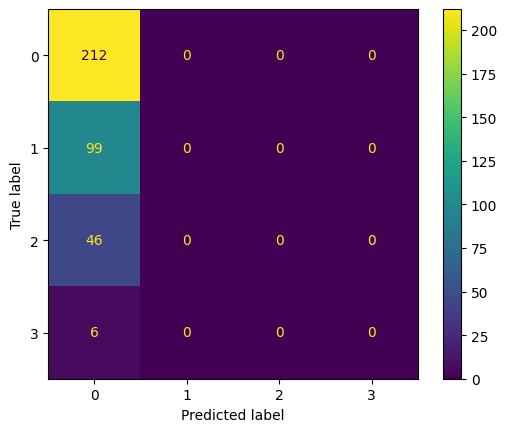

In [39]:
# Build the model
input_shape = (X_train_imp.shape[1],)
num_classes = len(np.unique(Y_train_imp))
model = build_model(input_shape, num_classes)

# Convert target variables to categorical format
Y_train_categorical = to_categorical(Y_train_imp)
Y_test_categorical = to_categorical(Y_test_imp)

# Train the model
history = model.fit(X_train_imp, Y_train_categorical, epochs=10, batch_size=32, validation_data=(X_test_imp, Y_test_categorical))

# Evaluate the model
_, train_accuracy = model.evaluate(X_train_imp, Y_train_categorical, verbose=0)
_, test_accuracy = model.evaluate(X_test_imp, Y_test_categorical, verbose=0)

print("\n\n")
print(f"Training Accuracy: {train_accuracy:.4f}")


# Predict on test data
nn_model_pred = model.predict(X_test) # Use the trained model to predict class labels for the test data
nn_model_pred = multiClassPredictionConverter(nn_model_pred)

# Evaluate Network Model performance
comprehensiveTestMetrics("Neural Network with KNN Imputation Model", Y_test, nn_model_pred)

This model actually ended up performing worse than the baseline model. Despite a high model test accuracy of 0.584, all the classifications are of the predicted label zero, resulting in both a low quadratic kappa score of 0.0 and a weighted average of 0.34. We will need to account for class weightage and find better hyperparameters in order to strengthen the model to classify the minority classes better.

### Class Weights

Introducing class weights to handle class imbalance:

Class weights are used to adjust the importance of different classes during model training and ensures that the model does not overly favor the majority class. class_weight = 'balanced' is set as it will have higher weights for classes with fewer samples and classes with more samples will have lower weights. The function, compute_class_weight, will return an array of weights (class_weights), where each weight corresponds to a class in the dataset. enumerate(class_weights) will assign an index i to each weight and the index corresponds to the class label. In the dictionary, the key is the class label, and the value is the weight for the class. This dictionary is necessary when passing class weights to an ML training function.

In imbalanced datasets, models often perform poorly on minority classes because they are underrepresented. Class weights help the model pay more attention to minority classes by penalizing misclassifications for these classes more heavily. This approach is particularly useful in multi-class classification problems where oversampling may lead to overfitting.


In [40]:
# Compute class weights for handling class imbalance
class_weights = compute_class_weight(
    class_weight='balanced',     # Balances class weights inversely proportional to class frequencies
    classes=np.unique(Y_train),  # Unique classes in the target variable
    y=Y_train                    # Target variable used to compute class weights
)

class_weights_dict = {i: weight for i, weight in enumerate(class_weights)}  # Convert class weights to a dictionary

###Focal Loss Function

Focal loss is designed to handle class imbalance by focusing more on hard-to-classifiy examples while reducing the impact of easy-to-classify examples. gamma is a focusing parameter that reduces the relative importance of well-classified examples and alpha is a weighting factor that balances the importance of classes. Larger values of gamma result in more focus on hard-to-classify examples, while alpha helps to adress the issue of class imabalance by assigning a higher weight to minority classes.

In [41]:
# Define a custom focal loss function to handle class imbalance
# Focal loss modifies standard cross-entropy to focus more on hard-to-classify examples.
# It reduces the relative impact of well-classified examples and balances the contribution of minority classes.

def focal_loss(gamma=2., alpha=0.25):
    # `gamma` (focusing parameter): Controls how much the loss focuses on harder examples.
    # Larger values of `gamma` make the loss focus more on misclassified examples.
    # `alpha` (balancing factor): Weights the importance of each class to handle class imbalance.

    def loss(y_true, y_pred):
        epsilon = tf.keras.backend.epsilon()  # Add a small constant to prevent division by zero or log(0).
        y_pred = tf.clip_by_value(y_pred, epsilon, 1. - epsilon)  # Ensure predictions stay within [epsilon, 1 - epsilon].

        cross_entropy = -y_true * tf.math.log(y_pred)  # Calculate standard cross-entropy loss for each class.
        # `y_true` is one-hot encoded, so the log term applies only to the true class.

        weight = alpha * tf.math.pow(1 - y_pred, gamma)  # Apply the focal weighting.
        # `1 - y_pred` represents the confidence gap for the true class (how wrong the prediction was).
        # Raising it to the power of `gamma` emphasizes harder-to-classify examples (lower `y_pred`).

        return tf.reduce_sum(weight * cross_entropy, axis=1)  # Combine focal weight with cross-entropy and sum over classes.
        # This gives the total loss for each example in the batch.

    return loss  # Return the nested loss function to be used during model training.

### Hyperparameter Tuning

Hyperparameter tuning is a crucial technique for optimizing neural network models, allowing systematic exploration and refinement of key parameters like learning rate, dropout rates, number of training epochs, etc. This process can potentially lead to more robust models.

The following experiment is to create a neural network model that accounts for imbalanced classes by both containing class weights for each class and gauging the model using the focal loss. Hyperparameter tuning will be used for the number of units per NN Dense layer and dropout rates for each dropout layer, model learning rate, and focal loss parameters.

In [42]:
def build_model(hp):
    """
    Builds a neural network model with hyperparameters to be tuned.

    Args:
        hp: HyperParameters object from keras_tuner.

    Returns:
        keras.Model: The compiled neural network model.
    """
    num_classes = len(np.unique(Y_train))

    model = keras.Sequential()

    # Tune the number of units in the first Dense layer
    # Choose an optimal value between 32-512 with a step of 32
    hp_units = hp.Int('units', min_value=32, max_value=512, step=32)
    model.add(Dense(units=hp_units, activation='relu', input_shape=(X_train.shape[1],)))

    # Tune the dropout rate for the first dropout layer
    # Choose an optimal value between 0.0 and 0.5 with a step of 0.1
    hp_dropout = hp.Float('dropout', min_value=0.0, max_value=0.5, step=0.1)
    model.add(Dropout(hp_dropout))

    # Tune the number of units in the second Dense layer
    # Choose an optimal value between 32-512 with a step of 32
    hp_units2 = hp.Int('units_2', min_value=32, max_value=512, step=32)
    model.add(Dense(units=hp_units2, activation='relu'))

    # Tune the dropout rate for the second dropout layer
    # Choose an optimal value between 0.0 and 0.5 with a step of 0.1
    hp_dropout2 = hp.Float('dropout_2', min_value=0.0, max_value=0.5, step=0.1)
    model.add(Dropout(hp_dropout2))

    model.add(Dense(num_classes, activation='softmax'))

    # Tune the learning rate for the optimizer
    # Utilizing focal loss to improve upon smaller class identification
    # Choose an optimal value from 0.01, 0.001, or 0.0001
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
    hp_focal_loss_gamma = hp.Choice('focal_loss_gamma', values=[2, 3, 5])
    hp_focal_loss_alpha = hp.Choice('focal_loss_alpha', values=[0.1, 0.25, 0.5])
    model.compile(loss=focal_loss(hp_focal_loss_gamma, hp_focal_loss_alpha),
                  optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
                  metrics=['accuracy'])

    return model

Trial 30 Complete [00h 00m 06s]
val_accuracy: 0.584022045135498

Best val_accuracy So Far: 0.584022045135498
Total elapsed time: 00h 02m 14s
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.5362 - loss: 3.3385 - val_accuracy: 0.5840 - val_loss: 1.6762
Epoch 2/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5893 - loss: 3.2709 - val_accuracy: 0.5840 - val_loss: 1.6762
Epoch 3/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5893 - loss: 3.2709 - val_accuracy: 0.5840 - val_loss: 1.6762
Epoch 4/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5893 - loss: 3.2709 - val_accuracy: 0.5840 - val_loss: 1.6762
Epoch 5/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5893 - loss: 3.2709 - val_accuracy: 0.5840 - val_loss: 1.6762
Epoch 6/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5893 - loss: 3.2709 - val_accuracy: 0.5840 - val_loss: 1.6762
Epoch 7/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5893 - loss: 3.2709 - val_accuracy: 0.5840 - val_loss: 1.6762
Epoch 8/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5893 - loss: 3.2709 - val_accuracy: 0.5840 - val_loss: 1.6762
Epo

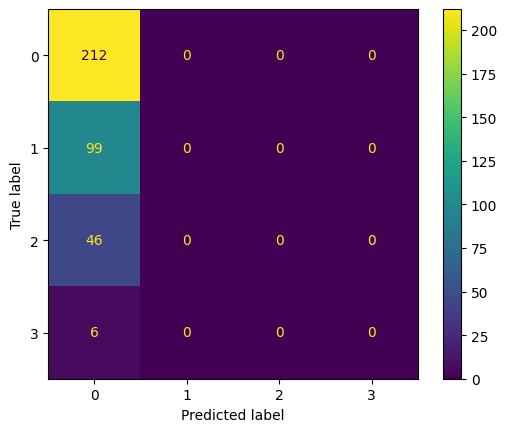

In [43]:
# Convert target variables to categorical format
Y_train_categorical = to_categorical(Y_train)
Y_test_categorical = to_categorical(Y_test)

# Initialize Hyperband tuner
tuner = kt.Hyperband(
    build_model,
    objective='val_accuracy',
    max_epochs=10,
    factor=3,
    directory='my_dir',
    project_name='intro_to_kt'
)

# Perform hyperparameter search
tuner.search(X_train, Y_train_categorical, epochs=10, validation_data=(X_test, Y_test_categorical))

# Get the best hyperparameters and model
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
best_model = tuner.hypermodel.build(best_hps)

# Train the best model
history = best_model.fit(X_train,
                        Y_train_categorical,
                        epochs=10, batch_size=32,
                        class_weight=class_weights_dict,
                        validation_data=(X_test, Y_test_categorical)
                        )

# Evaluate the best model
_, train_accuracy = best_model.evaluate(X_train, Y_train_categorical, verbose=0)
_, test_accuracy = best_model.evaluate(X_test, Y_test_categorical, verbose=0)
print("\n\nTraining Accuracy: ",round(train_accuracy, 4))

# Predict on test data
hyp_test_pred = best_model.predict(X_test)
hyp_test_pred = multiClassPredictionConverter(hyp_test_pred)
print(f"\n\nBest Hyperparameters: {best_hps.values}")

# Evaluate Improved Model performance
comprehensiveTestMetrics("Class Weights + Focal Loss + Hyperparameter Neural Network Model", Y_test, nn_model_pred)

It is surprising that despite trying different hyperparameters within hyperparameter tuning and trying to account for different class sizes with class weights and usage of focal loss, the majority class is being predicted each time with our model.

As a follow-up, we will try oversampling the minority classes prior to modeling to make our model more robust.

## Hyperparameter tuning after Oversampling

#### Oversampling Data

Oversampling data is a method to address class imbalance, particularly in scenarios where minority classes are underrepresented and could lead to biased model predictions. By generating synthetic or replicated samples of the minority class, oversampling helps create a more balanced dataset that allows models to learn more effectively from all classes, improving the model's ability to recognize and predict less frequent but potentially critical data points.

In [44]:
# Before converting to categorical, apply SMOTE
smote = SMOTE(random_state=42)  # You can change the random_state if needed
X_train_resampled, Y_train_resampled = smote.fit_resample(X_train, Y_train)

# Now convert the resampled target to categorical
Y_train_categorical = to_categorical(Y_train_resampled)
Y_test_categorical = to_categorical(Y_test)


Reloading Tuner from my_dir/intro_to_kt/tuner0.json
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


107/107 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.2606 - loss: 2.9735 - val_accuracy: 0.2727 - val_loss: 2.9306
Epoch 2/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.2538 - loss: 3.0068 - val_accuracy: 0.2727 - val_loss: 2.9306
Epoch 3/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.2538 - loss: 3.0068 - val_accuracy: 0.2727 - val_loss: 2.9306
Epoch 4/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.2538 - loss: 3.0068 - val_accuracy: 0.2727 - val_loss: 2.9306
Epoch 5/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.2538 - loss: 3.0068 - val_accuracy: 0.2727 - val_loss: 2.9306
Epoch 6/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.2538 - loss: 3.0068 - val_accuracy: 0.2727 - val_loss: 2.9306
Epoch 7/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.2538 - loss: 3.0068 - val_accuracy: 0.2727 - val_loss: 2.9306
Epoch 8/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.2538 - loss: 3.0068 - val_accuracy: 0.2727 - val_

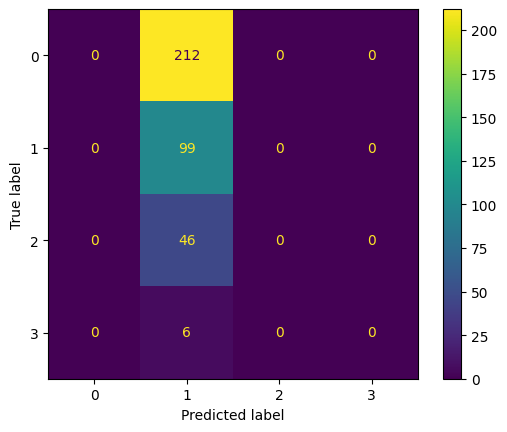

In [45]:
# Initialize Hyperband tuner
tuner = kt.Hyperband(
    build_model,
    objective='val_accuracy',
    max_epochs=10,
    factor=3,
    directory='my_dir',
    project_name='intro_to_kt'
)

# Perform hyperparameter search
tuner.search(X_train_resampled, Y_train_categorical, epochs=10, validation_data=(X_test, Y_test_categorical))

# Get the best hyperparameters and model
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
best_model = tuner.hypermodel.build(best_hps)

# Train the best model
history = best_model.fit(X_train_resampled, Y_train_categorical, epochs=10, batch_size=32, validation_data=(X_test, Y_test_categorical))

# Evaluate the best model
_, train_accuracy = best_model.evaluate(X_train_resampled, Y_train_categorical, verbose=0)
_, test_accuracy = best_model.evaluate(X_test, Y_test_categorical, verbose=0)
print(f"\n\nTraining Accuracy: {train_accuracy:.4f}")

# Predict on test data
oversampl_test_pred = best_model.predict(X_test)
oversampl_test_pred = multiClassPredictionConverter(oversampl_test_pred)
print(f"Best Hyperparameters: {best_hps.values}")

# Evaluate Improved Model performance
comprehensiveTestMetrics("Oversampling + Hyperparameter Neural Network Model", Y_test, oversampl_test_pred)


In this model, oversampling shifted the skew from the majority class to a minority class, reducing both the accuracy while not being able to address the issue of proper classifications throughout classes.

Given a lower set of model scores than expected with neural networks, we pivot over to the standard machine learning models.

## Further data pre-processing

In [46]:
# Scale features for PCA
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Apply SMOTE to balance the dataset
smote = SMOTE(random_state=42)
X_train_resampled, Y_train_resampled = smote.fit_resample(X_train_scaled, Y_train)

# Apply PCA to retain 95% variance
pca = PCA(n_components=0.95)
X_train_pca = pca.fit_transform(X_train_resampled)
X_test_pca = pca.transform(X_test_scaled)

# Convert targets to categorical
Y_train_categorical = to_categorical(Y_train_resampled)
Y_test_categorical = to_categorical(Y_test)

print(f"X_train_pca shape: {X_train_pca.shape}")
print(f"Y_train_categorical shape: {Y_train_categorical.shape}")
print(f"Original X_train shape: {X_train.shape}")
print(f"Original Y_train shape: {Y_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"Y_test shape: {Y_test.shape}")

X_train_pca shape: (3408, 16)
Y_train_categorical shape: (3408, 4)
Original X_train shape: (1450, 38)
Original Y_train shape: (1450,)
X_test shape: (363, 38)
Y_test shape: (363,)


##Logistic Regression Implementation

Logistic regression is a simple linear model that represents a strong baseline for classification tasks. It provides weights for each feature that show their importance in making predictions. The class_weight='balanced' parameter handles imbalanced datasets by assigning higher importance to minority classes and logistic regression scales well to high-dimensional data after PCA.

Training Accuracy: 0.6491


Logistic Regression Test Performance:
  Test Accuracy: 0.5482
  Quadratic Kappa Score: 0.4177

Classification Report:
               precision    recall  f1-score   support

         0.0       0.79      0.68      0.73       212
         1.0       0.42      0.31      0.36        99
         2.0       0.25      0.46      0.33        46
         3.0       0.13      0.50      0.21         6

    accuracy                           0.55       363
   macro avg       0.40      0.49      0.40       363
weighted avg       0.61      0.55      0.57       363



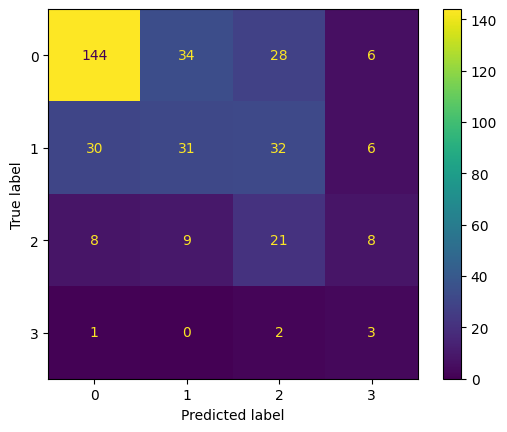

In [47]:
# Train logistic regression model
log_reg = LogisticRegression(
    class_weight='balanced',                    # Adjusts weights inversely proportional to class frequencies to handle class imbalance
    max_iter=1000,                              # Set the maximum number of iterations to 1000 for the solver to converge
    random_state=42)                            # Ensure reproducibility by setting a random seed

log_reg.fit(X_train_pca, Y_train_resampled)     # Train the model using PCA-transformed features and resampled labels

# Evaluate on training data
log_reg_train_pred = log_reg.predict(X_train_pca)
log_reg_train_accuracy = accuracy_score(Y_train_resampled, log_reg_train_pred)
print("Training Accuracy:", round(log_reg_train_accuracy, 4))

# Predict on test data
log_reg_pred = log_reg.predict(X_test_pca)      # Train the model using PCA-transformed features and resampled labels

# Evaluate logistic regression performance
comprehensiveTestMetrics("Logistic Regression", Y_test, log_reg_pred)

After scaling, balancing, and applying PCA to the data, a logistic regression model is performing as a more robust model than the prior neural network models as it is providing a better distribution amongst the classes. The quadratic kappa score has jumped to 0.4177 and the F1 score is 0.57 despite the more even distribution of classifications. We will still explore other models that can help make the classifications more accurate.

##Random Forest Implementation

Random Forest combines predictions from multiple decision trees to improve accuracy, robustness, and obtains non-linear relationships between features and target variables. Random forests provide feature importance scores the provide more information as to which features contribute the most to the predictions. The class_weight='balanced' parameters handles imbalanced datasets by weighting minority classes more heavily and ensemble learning (done by averaging multiple trees) makes it less prone to overfitting compared to individual decision trees.

Training Accuracy: 1.0


Random Forest Test Performance:
  Test Accuracy: 0.5234
  Quadratic Kappa Score: 0.3642

Classification Report:
               precision    recall  f1-score   support

         0.0       0.71      0.71      0.71       212
         1.0       0.27      0.24      0.26        99
         2.0       0.25      0.33      0.28        46
         3.0       0.33      0.17      0.22         6

    accuracy                           0.52       363
   macro avg       0.39      0.36      0.37       363
weighted avg       0.53      0.52      0.52       363



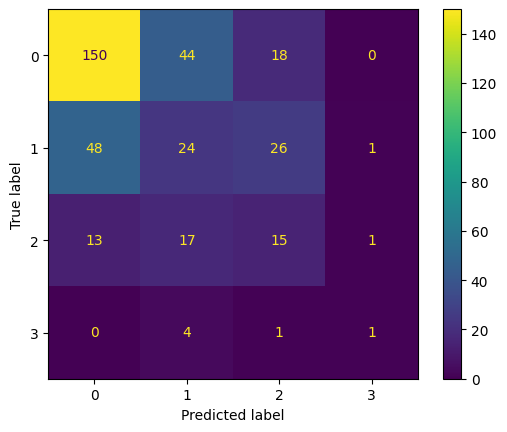

In [48]:
# Train random forest model
rf = RandomForestClassifier(
    class_weight='balanced',              # Adjust weights inversely proportional to class frequencies to handle class imbalance
    n_estimators=100,                     # Number of decision trees (estimators) in the forest
    random_state=42)                      # Ensure reproducibility by setting a random seed

rf.fit(X_train_pca, Y_train_resampled)    # Train the model using PCA-transformed features and resampled labels

# Evaluate on training data
rf_train_pred = rf.predict(X_train_pca)
rf_train_accuracy = accuracy_score(Y_train_resampled, rf_train_pred)
print("Training Accuracy:", round(rf_train_accuracy, 4))

# Predict on test data
rf_pred = rf.predict(X_test_pca)          # Use the trained model to predict class labels for the test data

# Evaluate logistic regression performance
comprehensiveTestMetrics("Random Forest", Y_test, rf_pred)

Utilization of random forest classification performs better than the neural networks, but has an overall lower classification accuracy and quadratic kappa score than the logistic regression model. It is overfitting on the training data (training accuracy of 1.0), so it has a problem generalizing to new data.

##XGBoost Implementation

XGBoost builds an ensemble of decision trees sequentially and optimizes performance by correction errors from previous models. The scale_pos_weight parameter promotes tuning for imbalanced datasets by assigning higher importance to minority classes. XGBoost supports many different hyperparameters, loss functions, and evaluation metrics and is know for its strong predictive performance when working with structured data.

Training Accuracy: 1.0


XGBoost Test Performance:
  Test Accuracy: 0.5427
  Quadratic Kappa Score: 0.4174

Classification Report:
               precision    recall  f1-score   support

         0.0       0.73      0.72      0.73       212
         1.0       0.33      0.28      0.30        99
         2.0       0.23      0.30      0.26        46
         3.0       0.25      0.33      0.29         6

    accuracy                           0.54       363
   macro avg       0.39      0.41      0.39       363
weighted avg       0.55      0.54      0.54       363



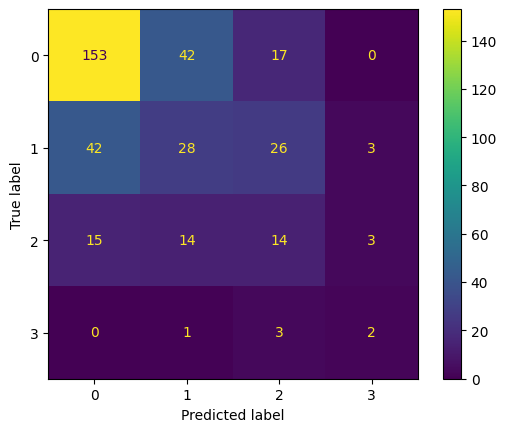

In [49]:
# Train XGBoost model
xgb = XGBClassifier(
    eval_metric='mlogloss',           # Sets the evaluation metric to multi-class log loss which will measure the model's performance
    random_state=42)                  # Ensure reproducibility by setting a random seed

xgb.fit(X_train_pca, Y_train_resampled) # Train the model using PCA- transformed features and resampled labels

# Evaluate on training data
xgb_train_pred = xgb.predict(X_train_pca)
xgb_train_accuracy = accuracy_score(Y_train_resampled, xgb_train_pred)
print("Training Accuracy:", round(xgb_train_accuracy, 4))

# Predict on test data
xgb_pred = xgb.predict(X_test_pca) # Use the trained model to predict class labels for the test data

# Evaluate logistic regression performance
comprehensiveTestMetrics("XGBoost", Y_test, xgb_pred)

Utilization of XGBoost also performs better than the neural networks and the random forest implementation, but has an overall lower classification accuracy and quadratic kappa score than the logistic regression model. It is overfitting on the training data (training accuracy of 1.0), so it has a problem generalizing to new data.

# Summary

In summary, logistic regression has provided the best performance amongst our models and provides a basis for further improvement. Though Neural Networks, Random Forest, and XGBoost are more complex and can handle non-linearities, offering a comparison with advanced models, Logistic regression ended up working well with the data decision boundaries while being robust to overfitting and handling high-dimensional data with imbalanced classes well.